In [2]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import tensorflow_hub as hub
embed = hub.load("../../model/")

In [5]:
data = pd.read_csv("../../data/english_dataset/english_dataset.tsv",sep="\t")
data.head()

,text_id,text,task_1,task_2,task_3
0,hasoc_en_1,#DhoniKeepsTheGlove | WATCH: Sports Minister K...,NOT,NONE,NONE
1,hasoc_en_2,@politico No. We should remember very clearly ...,HOF,HATE,TIN
2,hasoc_en_3,@cricketworldcup Guess who would be the winner...,NOT,NONE,NONE
3,hasoc_en_4,Corbyn is too politically intellectual for #Bo...,NOT,NONE,NONE
4,hasoc_en_5,All the best to #TeamIndia for another swimmin...,NOT,NONE,NONE


In [4]:
test_data = pd.read_csv("../../data/english_dataset/hasoc2019_en_test-2919.tsv", sep="\t")
test_data.head()

,text_id,text,task_1,task_2,task_3
0,hasoc_en_902,West Bengal Doctor Crisis: Protesting doctors ...,NOT,NONE,NONE
1,hasoc_en_416,68.5 million people have been forced to leave ...,NOT,NONE,NONE
2,hasoc_en_207,"You came, you saw .... we will look after the ...",NOT,NONE,NONE
3,hasoc_en_595,We'll get Brexit delivered by October 31st. ...,NOT,NONE,NONE
4,hasoc_en_568,Fuck you. Go back to the dark ages you cow @IB...,HOF,PRFN,UNT


In [13]:
list(data['task_3'].unique())

['NONE', 'TIN', 'UNT']

In [7]:
def create_label(labels, data):
    return data.map(labels, na_action='ignore')

In [8]:
def create_model(n_class):
    print("CLASSES:", n_class)
    model = Sequential()
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(n_class, activation='softmax'))
    return model

In [9]:
def make_train(model, X_train, X_test, y_train, y_test, X_val, y_val, epochs=5, batch_size=32):
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=False)
    results = model.evaluate(X_test, y_test)
    print("test loss, test acc:", results)
    return history.history, epochs

In [10]:
# label_task1, label_task2, label_task3 = {'NOT': 0, 'HOF': 1}, {'HATE':0, 'OFFN':1, 'PRFN':2}, {'TIN':0, 'UNT':1}
label = [{'NOT': 0, 'HOF': 1}, {'HATE':0, 'OFFN':1, 'PRFN':2, 'NONE':3}, {'TIN':0, 'UNT':1, 'NONE':2}]

CLASSES: 2
37/37 [==============================] - 0s 1ms/step - loss: 1.3978e-05 - accuracy: 1.0000
test loss, test acc: [1.3977988601254765e-05, 1.0]


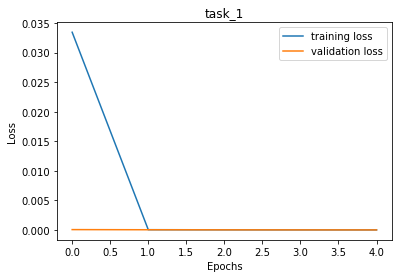

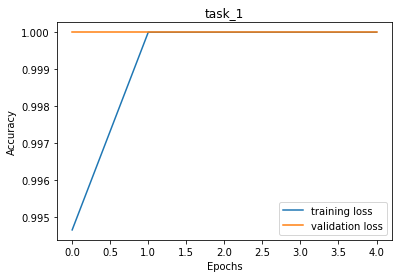

CLASSES: 4
37/37 [==============================] - 0s 1ms/step - loss: 1.5029e-05 - accuracy: 1.0000
test loss, test acc: [1.5028525012894534e-05, 1.0]


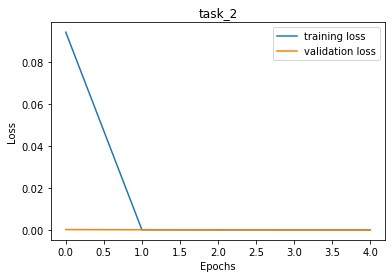

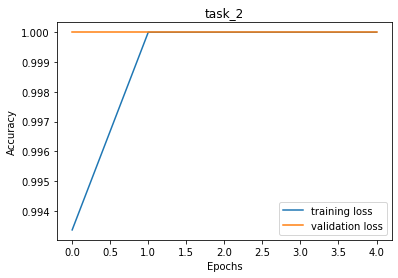

CLASSES: 3
37/37 [==============================] - 0s 1ms/step - loss: 1.1155e-05 - accuracy: 1.0000
test loss, test acc: [1.1154892490594648e-05, 1.0]


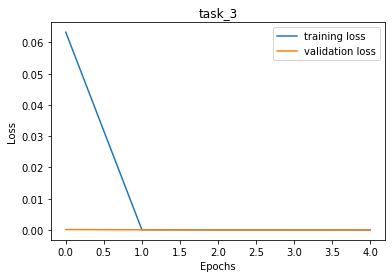

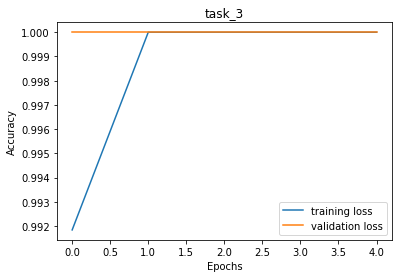

In [11]:
for i in range(1,4):
    col = "task_"+str(i)
    y = create_label(label[i-1], data[col])
    x = data[col]
    
    y_test, X_test = create_label(label[i-1], test_data[col]), test_data[col]
    
    X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.33, random_state=42)
#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)
    
    X_train_embed = embed(X_train)
    X_test_embed = embed(X_test)
    X_val_embed = embed(X_val)
    
    model = create_model(n_class = len(label[i-1]))
    history, epochs = make_train(model, X_train_embed, X_test_embed, y_train, y_test, X_val_embed, y_val)
    p_y = np.arange(epochs)
    plt.plot(p_y, history['loss'])
    plt.plot(p_y, history['val_loss'])
    plt.legend(['training loss','validation loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(col)
    plt.show()
    
    plt.plot(p_y, history['accuracy'])
    plt.plot(p_y, history['val_accuracy'])
    plt.legend(['training loss','validation loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(col)
    plt.show()